# Brain MRI Tumor Segmentation

## Imports

In [ ]:
!pip install opencv-python tqdm pandas numpy matplotlib scikit-image scikit-learn tensorflow

import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Check GPU

In [ ]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verify GPU usage
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


### Set Image Properties

In [ ]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [ ]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
mask_files = glob('/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_12.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_10.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_20.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_27.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_21.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_25.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_17.tif', '/content/drive/MyDrive/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA

3929

### Visualize Images

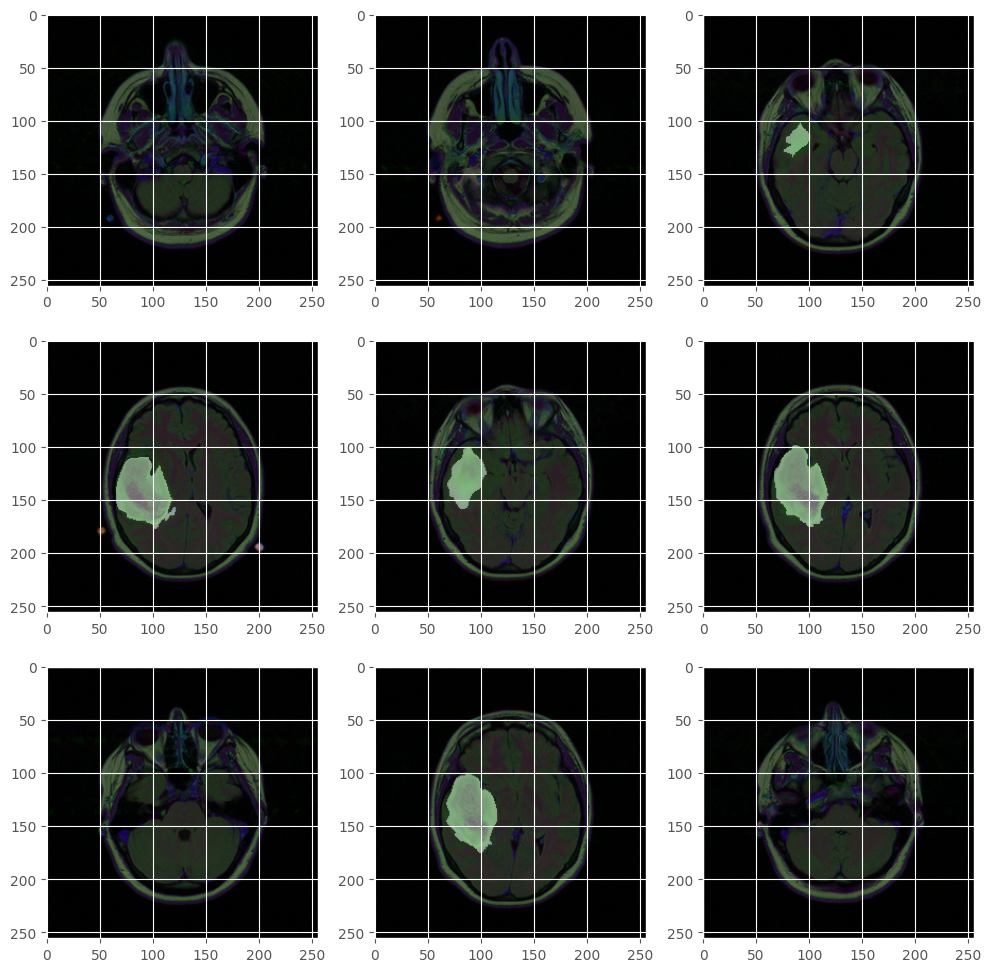

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')  # Add the directory path to sys.path

from unet import *
from utils import *


plot_from_img_path(3, 3 , image_filenames_train, mask_files )

## Prepare Dataset

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


## Train Model

In [ ]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f893030d570>>

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_param,
                            target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                           dict(),
                           target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])


checkpoint_path = '/content/drive/MyDrive/checkpoints/model_{epoch:02d}.hdf5'  # Caminho para salvar os checkpoints

checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

callbacks = [checkpoint_callback]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
89/88 [==============================] - ETA: -6s - loss: -0.1457 - binary_accuracy: 0.9368 - iou: 0.0812 - dice_coefficients: 0.1465Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: saving model to /content/drive/MyDrive/checkpoints/model_01.hdf5
88/88 [==============================] - 1269s 14s/step - loss: -0.1457 - binary_accuracy: 0.9368 - iou: 0.0812 - dice_coefficients: 0.1465 - val_loss: -0.0200 - val_binary_accuracy: 0.9899 - val_iou: 0.0103 - val_dice_coefficients: 0.0201
Epoch 2/10
89/88 [==============================] - ETA: 0s - loss: -0.2500 - binary_accuracy: 0.9886 - iou: 0.1443 - dice_coefficients: 0.2492
Epoch 2: saving model to /content/drive/MyDrive/checkpoints/model_02.hdf5
88/88 [==============================] - 154s 2s/step - loss: -0.2500 - binary_accuracy: 0.9886 - iou: 0.1443 - dice_coefficients: 0.2492 - val_loss: -0.0186 - val_binary_ac

## Evaluate Model

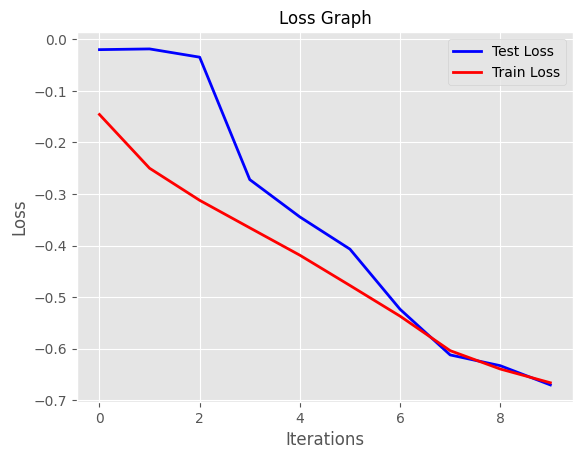

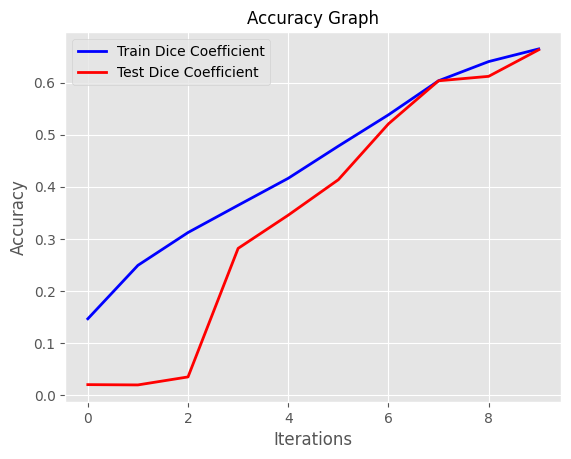

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-', linewidth=2, label='Test Loss')
plt.plot(train_loss_list, 'r-', linewidth=2, label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Graph', fontsize=12)
plt.legend()
plt.grid(True)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-', linewidth=2, label='Train Dice Coefficient')
plt.plot(test_dice_coeff_list, 'r-', linewidth=2, label='Test Dice Coefficient')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import sys, re
from unet import *
from utils import *

# Register the custom objects
custom_objects = {
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
}


checkpoint_dir = '/content/drive/MyDrive/checkpoints/'

checkpoint_files = os.listdir(checkpoint_dir)

model_files = [file for file in checkpoint_files if re.match(r'model_\d+\.hdf5', file)]

sorted_model_files = sorted(model_files, key=lambda x: int(re.search(r'model_(\d+)\.hdf5', x).group(1)), reverse=True)

# Get the latest model file name
latest_checkpoint_name = sorted_model_files[0]
model_path = f"{checkpoint_dir}{latest_checkpoint_name}"
print("Model: " + model_path)

# Load the latest model weights
model.load_weights(model_path)

# Set the custom objects for the loaded model
model.__setattr__('custom_objects', custom_objects)

Model: /content/drive/MyDrive/checkpoints/model_10.hdf5


In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 191s 17s/step - loss: -0.6689 - binary_accuracy: 0.9955 - iou: 0.5183 - dice_coefficients: 0.6768
Test Loss  -0.6688780784606934
Test IoU  0.9954579472541809
Test Dice Coefficient  0.5183200240135193


## Post Processing to unify predicted mask

In [ ]:
def postprocess_mask(mask):
    # Convert mask to the correct data type (8-bit unsigned integer)
    mask = mask.astype(np.uint8)

    # Apply closing operation to the mask with an appropriate structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closed_mask


1/1 [==============================] - 0s 22ms/step


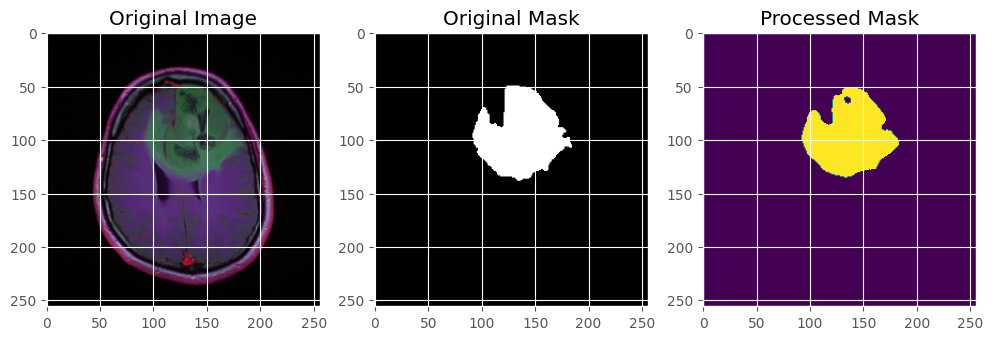

1/1 [==============================] - 0s 22ms/step


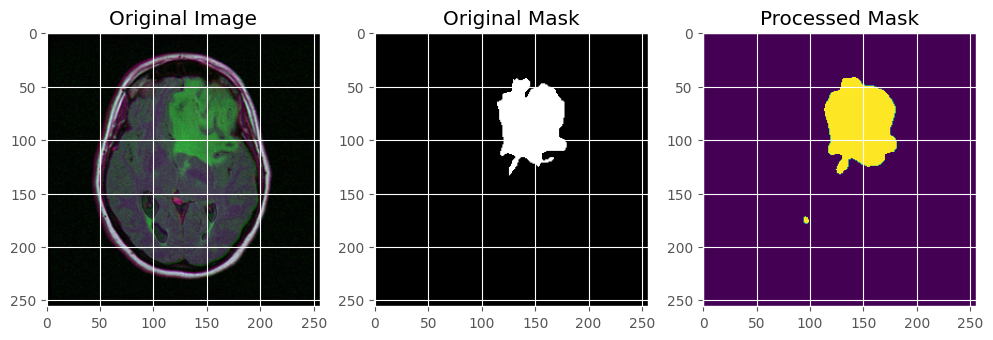

1/1 [==============================] - 0s 34ms/step


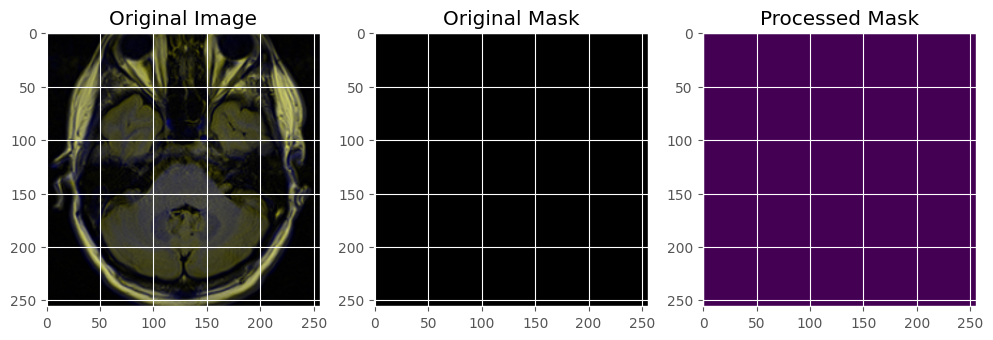

1/1 [==============================] - 0s 22ms/step


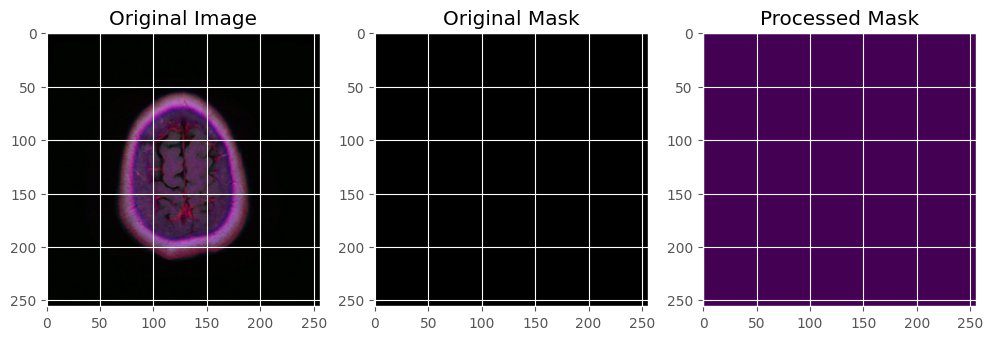

1/1 [==============================] - 0s 22ms/step


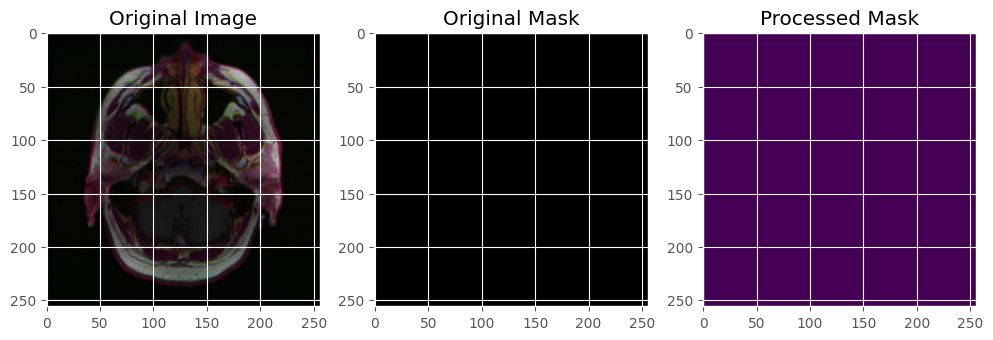

1/1 [==============================] - 0s 25ms/step


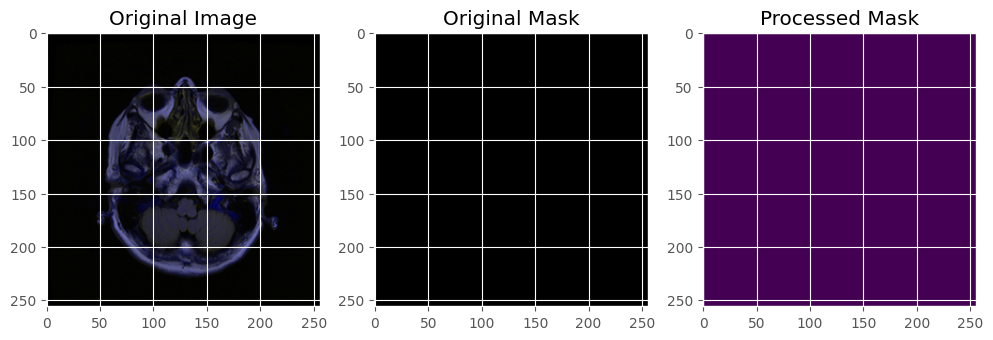

1/1 [==============================] - 0s 21ms/step


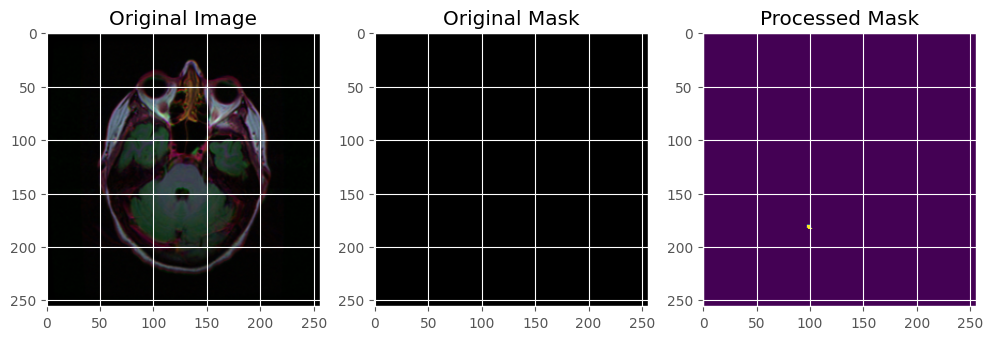

1/1 [==============================] - 0s 22ms/step


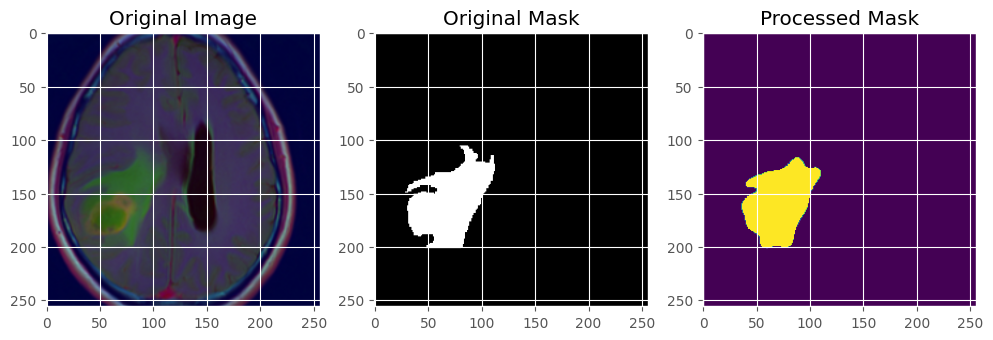

1/1 [==============================] - 0s 21ms/step


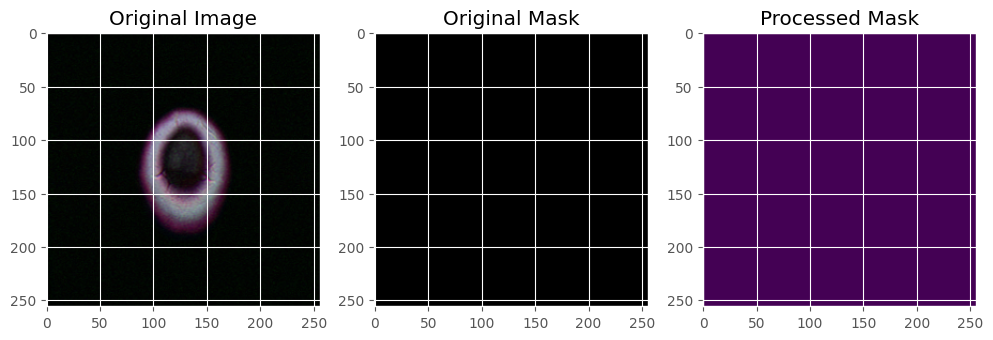

1/1 [==============================] - 0s 25ms/step


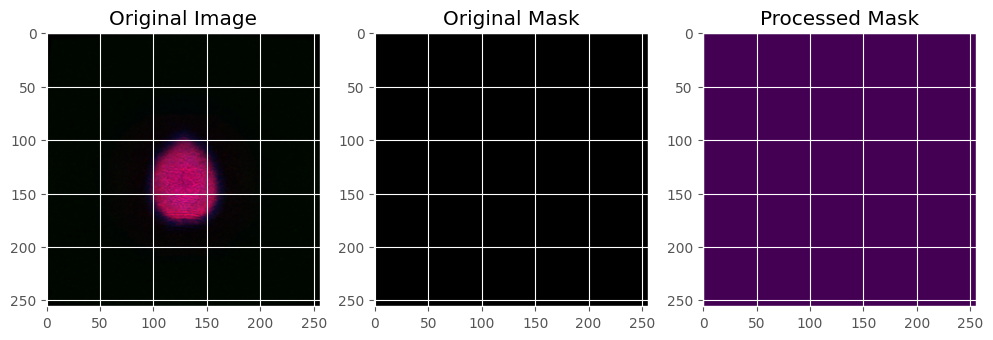

1/1 [==============================] - 0s 29ms/step


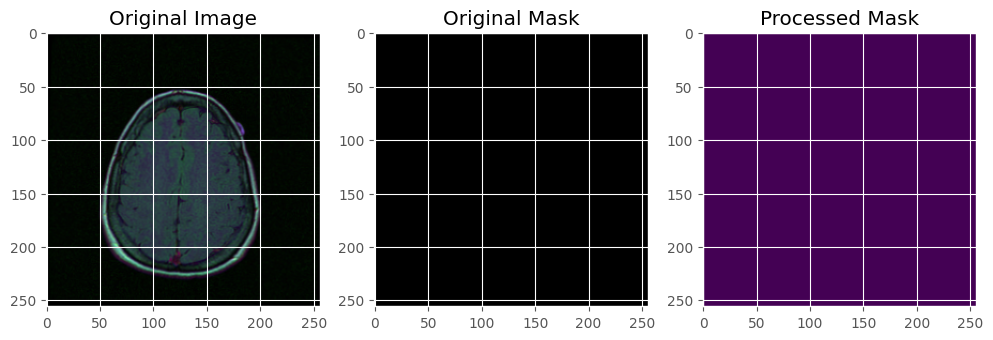

1/1 [==============================] - 0s 20ms/step


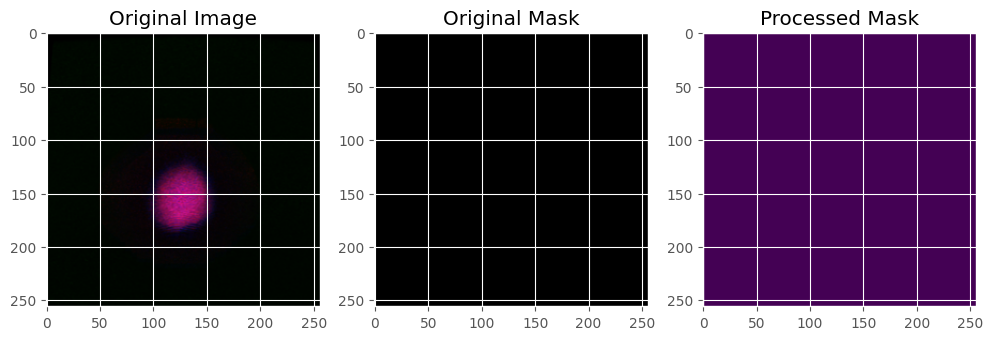

1/1 [==============================] - 0s 35ms/step


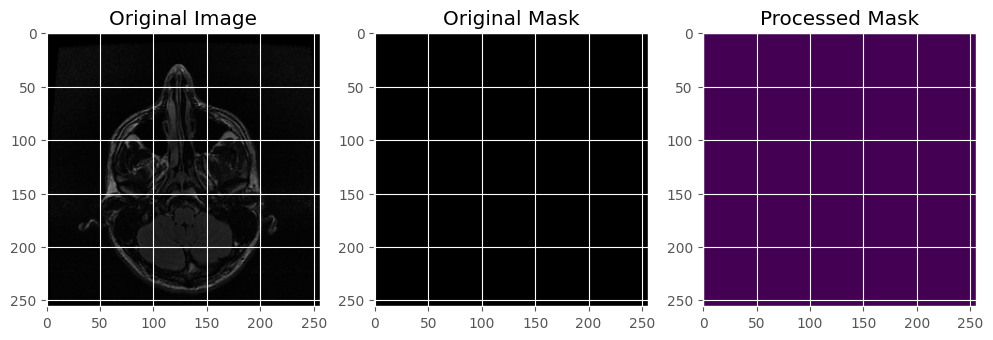

1/1 [==============================] - 0s 34ms/step


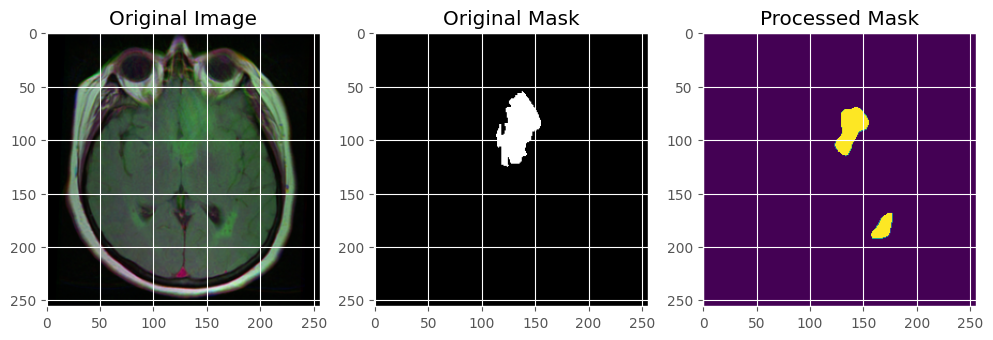

1/1 [==============================] - 0s 35ms/step


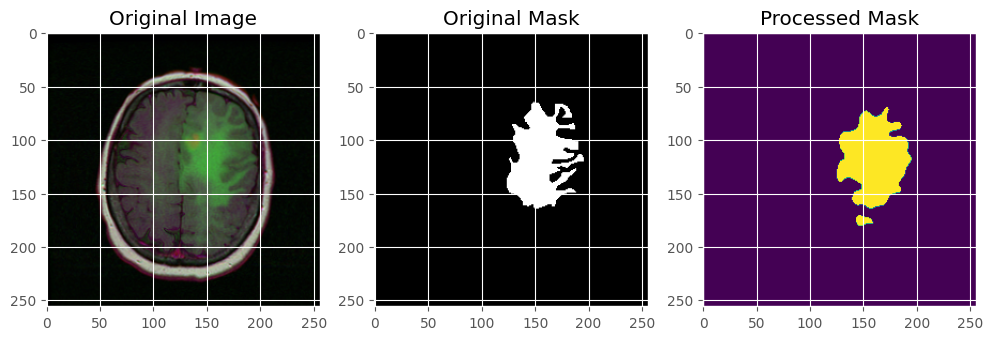

1/1 [==============================] - 0s 30ms/step


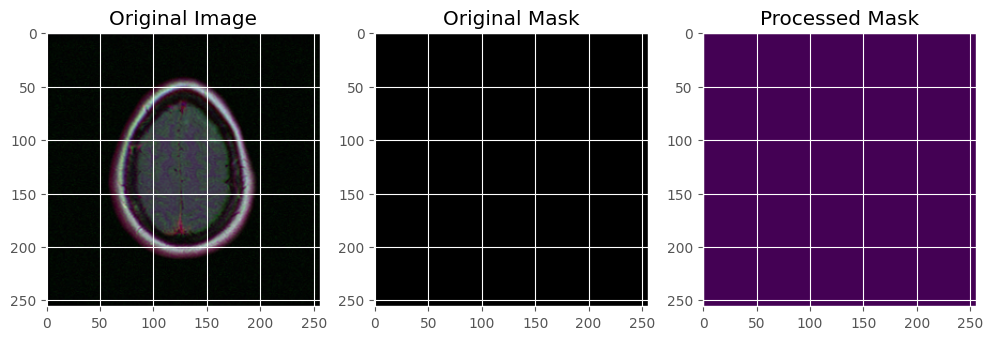

1/1 [==============================] - 0s 30ms/step


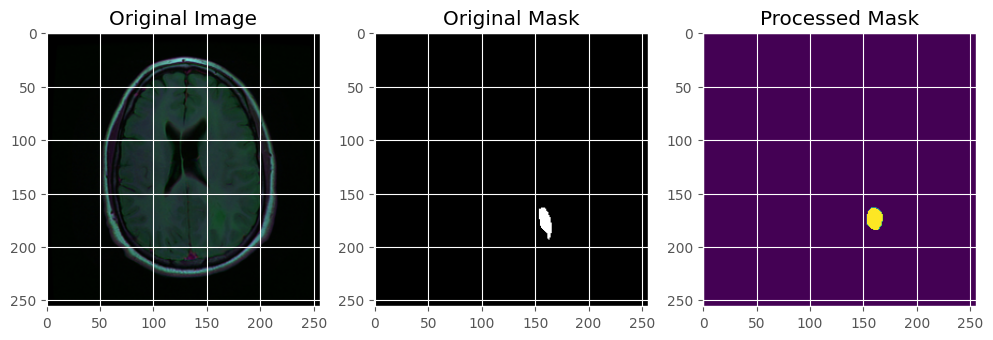

1/1 [==============================] - 0s 27ms/step


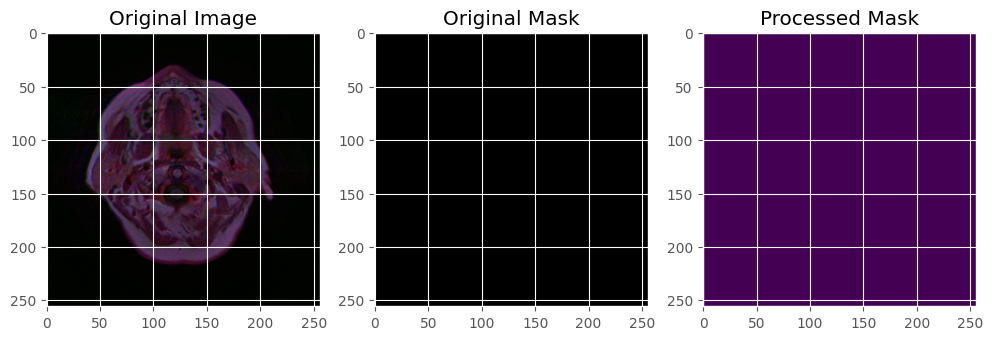

1/1 [==============================] - 0s 26ms/step


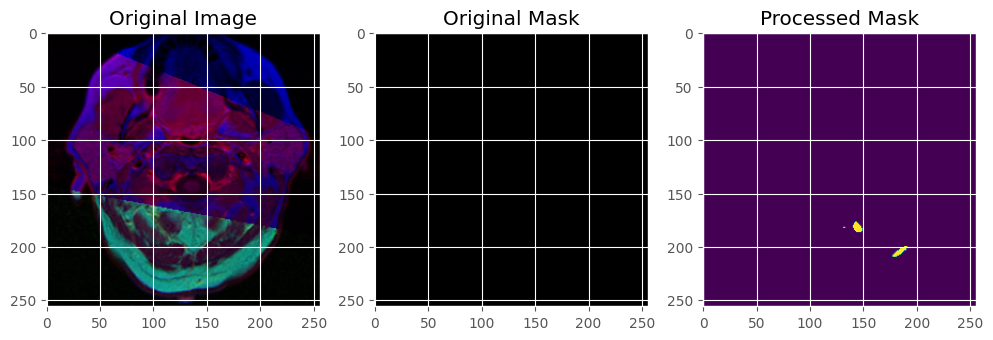

1/1 [==============================] - 0s 42ms/step


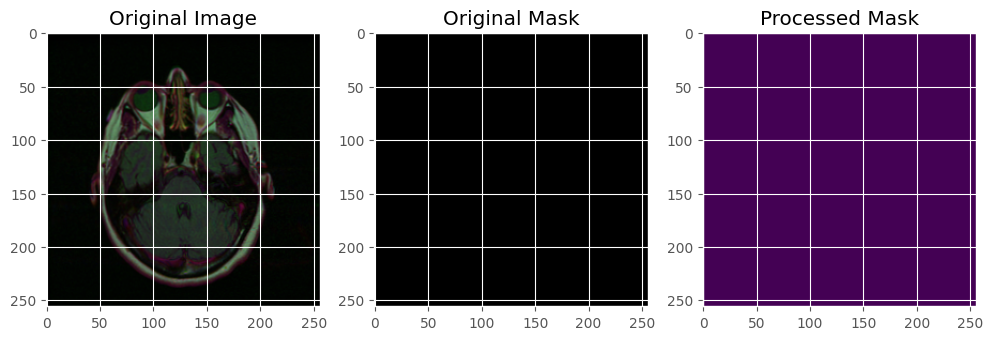

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    predicted_mask = np.squeeze(predicted_img) > 0.5
    
    processed_mask = postprocess_mask(predicted_mask)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(processed_mask)
    plt.title('Processed Mask')
    plt.show()